# Comparación Equitativa de Agentes en Foraging con Hiperparámetros Variados

Este cuaderno lleva a cabo una comparación completa entre distintos tipos de agentes en el juego Foraging, garantizando una evaluación equitativa mediante:

1. **Entrenamiento uniforme**: todos los agentes entrenan con la misma cantidad de episodios.
2. **Variedad de configuraciones**: cada tipo de agente se prueba con diferentes hiperparámetros.
3. **Evaluación exhaustiva**: cada agente se enfrenta a todos los demás.
4. **Análisis detallado**: visualizamos los resultados para identificar qué algoritmos y configuraciones funcionan mejor.

## Hiperparámetros a evaluar para cada tipo de agente

### Fictitious Play (FP)
- **FP_default**: configuración estándar sin sesgos iniciales.
- **FP_biased**: configuración con sesgo inicial hacia ciertas acciones (si aplica a Foraging).

### Regret Matching (RM)
- **RM_default**: política inicial uniforme.
- **RM_biased**: política inicial sesgada (si aplica a Foraging).

### Q-Learning Independiente (IQL)
- **IQL_default**: α=0.1, ε=0.1 (exploración equilibrada).
- **IQL_explore**: α=0.2, ε=0.3 (mayor exploración).
- **IQL_exploit**: α=0.05, ε=0.05 (mayor explotación).

### Joint-Action Learning con Modelado de Agente (JAL-AM)
- **JALAM_default**: α=0.1, ε=0.1 (configuración balanceada).
- **JALAM_explore**: α=0.2, ε=0.3 (mayor exploración).
- **JALAM_exploit**: α=0.05, ε=0.05 (mayor explotación).

# Comparación de Agentes en Foraging

Este cuaderno compara el desempeño de distintos agentes en el juego Foraging, evaluando diferentes hiperparámetros para conseguir una comparación justa.
Los agentes son:
- Fictitious Play (FP)
- Regret Matching (RM)
- Q-Learning Independiente (IQL)
- Joint-Action Learning con Modelado de Agente (JAL-AM)
- Agente Aleatorio (como línea base)

Vamos a entrenar los agentes de manera justa con diferentes hiperparámetros y luego ejecutar una serie de enfrentamientos entre distintas parejas de agentes.

## 1. Importaciones y configuración del entorno

Importamos las librerías necesarias y preparamos el entorno para el juego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

# Add project root to sys.path to allow importing custom modules
module_path = os.path.abspath(os.path.join('..', 'Simultaneous Games')) # Adjust if notebook is in a different subfolder
if module_path not in sys.path:
    sys.path.append(module_path)

from games.foraging import Foraging 
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

## 2. Carga del entorno de juego Foraging

In [2]:
# MODIFICADO: Configuración para Foraging
FIELD_SIZE = (5, 5)
NUM_PLAYERS = 2
NUM_FOOD_SITES = 2 # Assuming 1f means 1 food site, adjust if NUM_FOOD_SITES should be used directly
MAX_STEPS = 50

# Construct the config string based on the parameters
# Example: "Foraging-5x5-2p-2f-v3" (assuming v3 is a valid version)
# You might need to adjust the version or exact format based on lbforaging environment's expectations
config_string = f"Foraging-{FIELD_SIZE[0]}x{FIELD_SIZE[1]}-{NUM_PLAYERS}p-{NUM_FOOD_SITES}f-v3"

game = Foraging(config=config_string, seed=42) # Added seed for reproducibility
print("Foraging game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)
# Para Foraging, el espacio de acciones es discreto (0: arriba, 1: abajo, 2: izquierda, 3: derecha, 4: quedarse quieto)
# El espacio de observación es la posición de los agentes y la comida.

Foraging game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(6), 'agent_1': Discrete(6)}


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones que recuperan el estado guardado de los agentes entrenados en archivos `.pkl`.
(Estas funciones son genéricas y deberían funcionar, pero las rutas de los archivos deben ajustarse para Foraging)

In [3]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            agent.learned_policy = pickle.load(f)
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0) 
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_vs_random_trainings', game_name, f'agent_0_q_table.pkl')
    print(f"Attempting to load Q-table from: {q_table_path}") # DEBUG PRINT
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
        # DEBUG: Print some info about the loaded Q-table
        if agent.Q:
            print(f"  Q-table loaded. Number of states: {len(agent.Q)}")
            # Print a small sample of Q-values if the table is not too large or complex to print
            sample_state = next(iter(agent.Q)) if agent.Q else None
            if sample_state:
                print(f"  Sample Q-values for state '{sample_state}': {agent.Q[sample_state]}")
            if not any(any(v != 0 for v in q_vals) for q_vals in agent.Q.values()):
                 print("  WARNING: All Q-values in the loaded table are zero.")
        else:
            print("  WARNING: Q-table is empty after loading.")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
        print(f"  Fresh IQL agent Q-table state: {len(agent.Q)} states.") # Check initial Q-table state
    agent.epsilon = 0 
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0) 
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl') 

    if os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
            if 'Q_table' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q_table']
            if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
                agent.model_counts = saved_data['model_counts']
            if 'Q' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q']
            if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
                agent.opp_count = saved_data['opp_count']
            if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
                agent.joint_count = saved_data['joint_count']
        print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    else:
        print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
    agent.epsilon = 0 
    return agent

## 4. Cargar agentes entrenados para Foraging

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es Foraging y los agentes son “agent_0” y “agent_1”.
**MODIFICADO**: `GAME_NAME` a "Foraging_5x5_2p_1f" o el nombre de carpeta correspondiente.

In [4]:
GAME_NAME = "Foraging_5x5_2p_1f" # MODIFICADO: Nombre de la carpeta de entrenamiento para Foraging
agent_ids = game.agents

# Fictitious Play Configurations (sesgo inicial podría ser menos relevante o necesitar adaptación para Foraging)
fp_configs = [
    {"name": "FP_default", "params": {"initial": None, "seed": 42}},
    # {"name": "FP_biased", "params": {"initial": {agent_ids[0]: [ biased_counts_0 ], agent_ids[1]: [ biased_counts_1 ]}, "seed": 42}} # Adaptar si se usa
]

# Regret Matching Configurations (ídem para política inicial)
rm_configs = [
    {"name": "RM_default", "params": {"initial": None, "seed": 42}},
    # {"name": "RM_biased", "params": {"initial": np.array([ biased_policy_for_foraging ]), "seed": 42}} # Adaptar si se usa
]

# IQL Configurations (estos son más genéricos)
iql_configs = [
    {"name": "IQL_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42, "use_reward_shaping": True}}, # Habilitar reward shaping para Foraging
    {"name": "IQL_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42, "use_reward_shaping": True}},
    {"name": "IQL_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42, "use_reward_shaping": True}}
]

# JAL-AM Configurations (estos son más genéricos)
jalam_configs = [
    {"name": "JALAM_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "JALAM_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99}},
    {"name": "JALAM_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

def create_fp_agent(game_instance, agent_id, config):
    return FictitiousPlay(game=game_instance, agent=agent_id, **config["params"])

def create_rm_agent(game_instance, agent_id, config):
    return RegretMatching(game=game_instance, agent=agent_id, **config["params"])

def create_iql_agent(game_instance, agent_id, config):
    iql_config_obj = IQLAgentConfig(**config["params"])
    return IQLAgent(game=game_instance, agent=agent_id, config=iql_config_obj)

def create_jalam_agent(game_instance, agent_id, config):
    return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, **config["params"])

agents_pool = {}

random_agent_0 = RandomAgent(game, agent_ids[0])
random_agent_1 = RandomAgent(game, agent_ids[1])
agents_pool["Random"] = random_agent_0

print("Creating agent instances with different hyperparameters for Foraging...")

for config in fp_configs:
    # Cargamos el agente FP entrenado desde el disco
    # Asumimos que el agente 0 es el que se carga con esta configuración
    agent = load_fp_agent(game, agent_ids[0], GAME_NAME, 0) 
    # Sobrescribimos los parámetros si es necesario, aunque load_fp_agent ya configura el agente.
    # Si la carga falla, se usa uno nuevo con los params de config.
    if "initial" in config["params"]: agent.initial = config["params"]["initial"] # Ejemplo de cómo se podría forzar
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

for config in rm_configs:
    agent = load_rm_agent(game, agent_ids[0], GAME_NAME, 0)
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

for config_dict in iql_configs:
    # Para IQL, la configuración se pasa como un objeto IQLAgentConfig
    # El epsilon para evaluación se setea a 0 en load_iql_agent
    agent = load_iql_agent(game, agent_ids[0], GAME_NAME, 0, IQLAgentConfig(**config_dict["params"])) 
    agents_pool[config_dict["name"]] = agent
    print(f"Loaded/Created {config_dict['name']} agent for player 0")

for config in jalam_configs:
    # JALAM también se carga y se le setea epsilon a 0 para evaluación en load_jalam_agent
    agent = load_jalam_agent(game, agent_ids[0], GAME_NAME, 0) 
    # Podríamos querer forzar los parámetros de la config si la carga no los establece como esperamos
    # agent.alpha = config["params"]["alpha"] # etc.
    agents_pool[config["name"]] = agent
    print(f"Loaded/Created {config['name']} agent for player 0")

print("\nAvailable agents for comparison:", list(agents_pool.keys()))

Creating agent instances with different hyperparameters for Foraging...
Loaded Fictitious Play agent agent_0 for Foraging_5x5_2p_1f from fp_trainings/Foraging_5x5_2p_1f/agent_0_fp_counts.pkl
Loaded/Created FP_default agent for player 0
Loaded Regret Matching agent agent_0 for Foraging_5x5_2p_1f from rm_trainings/Foraging_5x5_2p_1f/agent_0_rm_policy.pkl
Loaded/Created RM_default agent for player 0
Attempting to load Q-table from: iql_vs_random_trainings/Foraging_5x5_2p_1f/agent_0_q_table.pkl
Loaded IQL agent agent_0 for Foraging_5x5_2p_1f from iql_vs_random_trainings/Foraging_5x5_2p_1f/agent_0_q_table.pkl
  Q-table loaded. Number of states: 642
  Sample Q-values for state '(np.float32(3.0), np.float32(1.0), np.float32(1.0), np.float32(3.0), np.float32(3.0), np.float32(1.0), np.float32(2.0), np.float32(4.0), np.float32(1.0))': [1.0771299  1.06842374 1.06430108 1.08801    1.06700072 1.0771299 ]
Loaded/Created IQL_default agent for player 0
Attempting to load Q-table from: iql_vs_random_tr

## 5. Función de simulación

Esta función ejecuta un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.
**MODIFICADO**: La simulación para Foraging implica múltiples pasos por episodio.

In [5]:
def run_match_foraging(game_instance, agent1, agent2, num_episodes):
    total_reward_agent1 = 0
    total_reward_agent2 = 0
    history_rewards_agent1 = [] # Added
    history_rewards_agent2 = [] # Added

    # Ensure agent_ids are correctly fetched from the game instance
    # This assumes game_instance.possible_agents returns a list like ['player_0', 'player_1']
    agent_ids = game_instance.possible_agents 
    agent1_id = agent_ids[0]
    agent2_id = agent_ids[1]

    for episode in range(num_episodes):
        game_instance.reset() # Call reset for its side effects
        observations = game_instance.observations # Get observations from the instance attribute
        infos = game_instance.infos               # Get infos from the instance attribute

        terminated = {agent_id: False for agent_id in agent_ids}
        truncated = {agent_id: False for agent_id in agent_ids}
        
        # Reset agents if they have a reset method and pass initial observation if needed
        if hasattr(agent1, 'reset'):
            try:
                # Try resetting with observation first
                agent1.reset(observations[agent1_id])
            except TypeError:
                # If that fails (e.g., reset takes no args or different args), try without
                try:
                    agent1.reset()
                except Exception as e:
                    print(f"Error resetting agent1: {e}") # Or handle more gracefully
        
        if hasattr(agent2, 'reset'):
            try:
                agent2.reset(observations[agent2_id])
            except TypeError:
                try:
                    agent2.reset()
                except Exception as e:
                    print(f"Error resetting agent2: {e}")


        current_episode_reward_agent1 = 0
        current_episode_reward_agent2 = 0
        current_step = 0
        
        # The loop continues until the game ends (max_steps or all food collected)
        while not (all(terminated.values()) or all(truncated.values())) and current_step < MAX_STEPS:
            # Get actions from agents
            # Actions might require current observation: action1_val = agent1.action(observations[agent1_id])
            action1_val = agent1.action() 
            action2_val = agent2.action()
            
            actions = {agent1_id: action1_val, agent2_id: action2_val}

            # Unpack all return values from game_instance.step
            next_observations, rewards, terminated_update, truncated_update, infos_update = game_instance.step(actions)

            # Update terminated and truncated states
            terminated.update(terminated_update)
            truncated.update(truncated_update)
            
            # Accumulate rewards
            current_episode_reward_agent1 += rewards[agent1_id]
            current_episode_reward_agent2 += rewards[agent2_id]
            
            # Update observations for the next iteration if agents are state-dependent
            observations = next_observations

            current_step += 1

        total_reward_agent1 += current_episode_reward_agent1
        total_reward_agent2 += current_episode_reward_agent2
        history_rewards_agent1.append(current_episode_reward_agent1) # Added
        history_rewards_agent2.append(current_episode_reward_agent2) # Added

    avg_reward_agent1 = total_reward_agent1 / num_episodes if num_episodes > 0 else 0
    avg_reward_agent2 = total_reward_agent2 / num_episodes if num_episodes > 0 else 0

    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "total_reward_agent1": total_reward_agent1,
        "total_reward_agent2": total_reward_agent2,
        "history_agent1": history_rewards_agent1, # Added
        "history_agent2": history_rewards_agent2  # Added
    }

## 6. Definir parejas y ejecutar experimentos

Configuramos las parejas de agentes que se enfrentarán y ejecutamos los experimentos.

In [6]:
def get_agent_instance_foraging(agent_type_str, game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load, config_params=None):
    if agent_type_str == "Random":
        return RandomAgent(game_instance, agent_id_in_game)
    
    # Para agentes que se cargan, config_params se usa si la carga falla o para anular.
    # Para IQL, config_params se convierte en IQLAgentConfig.

    if agent_type_str == "FP":
        # Intenta cargar, si falla, crea uno nuevo con config_params
        try:
            agent = load_fp_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
            # Aquí podrías aplicar config_params si es necesario para anular algo de la carga
        except Exception as e:
            print(f"Failed to load FP agent, creating new. Error: {e}")
            base_config = {"initial": None, "seed": 42}
            if config_params: base_config.update(config_params)
            agent = FictitiousPlay(game=game_instance, agent=agent_id_in_game, **base_config)
        return agent
    
    elif agent_type_str == "RM":
        try:
            agent = load_rm_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
        except Exception as e:
            print(f"Failed to load RM agent, creating new. Error: {e}")
            base_config = {"initial": None, "seed": 42}
            if config_params: base_config.update(config_params)
            agent = RegretMatching(game=game_instance, agent=agent_id_in_game, **base_config)
        return agent
    
    elif agent_type_str == "IQL":
        # IQLAgentConfig necesita todos los parámetros definidos en su __init__
        default_iql_params = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42, "use_reward_shaping": True}
        if config_params: default_iql_params.update(config_params)
        iql_config_obj = IQLAgentConfig(**default_iql_params)
        
        # Intenta cargar, si falla, crea uno nuevo con iql_config_obj
        try:
            # load_iql_agent también aplica epsilon=0 para evaluación
            agent = load_iql_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load, config=iql_config_obj) 
        except Exception as e:
            print(f"Failed to load IQL agent, creating new. Error: {e}")
            agent = IQLAgent(game=game_instance, agent=agent_id_in_game, config=iql_config_obj)
            agent.epsilon = 0 # Asegurar modo evaluación
        return agent
    
    elif agent_type_str == "JALAM":
        base_jalam_params = {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}
        if config_params: base_jalam_params.update(config_params)
        try:
            # load_jalam_agent también aplica epsilon=0 para evaluación
            agent = load_jalam_agent(game_instance, agent_id_in_game, game_name_for_load, agent_idx_for_load)
            # Aplicar parámetros de config si es necesario para anular la carga
            # for key, value in base_jalam_params.items():
            #     if hasattr(agent, key):
            #         setattr(agent, key, value)
        except Exception as e:
            print(f"Failed to load JALAM agent, creating new. Error: {e}")
            agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id_in_game, **base_jalam_params)
            agent.epsilon = 0 # Asegurar modo evaluación
        return agent
    
    else:
        raise ValueError(f"Unknown agent type: {agent_type_str}")

# Mapeo de nombres de `agents_pool` a su tipo y configuración original (para recreación)
agent_creation_info = {}
for name in agents_pool: # agents_pool ya contiene instancias (potencialmente cargadas)
    if name == "Random":
        agent_creation_info[name] = {"type": "Random", "config_params": None}
    elif name.startswith("FP_"):
        # Busca la config original usada para crear/cargar esta instancia
        original_config = next(c for c in fp_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "FP", "config_params": original_config["params"]}
    elif name.startswith("RM_"):
        original_config = next(c for c in rm_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "RM", "config_params": original_config["params"]}
    elif name.startswith("IQL_"):
        original_config = next(c for c in iql_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "IQL", "config_params": original_config["params"]}
    elif name.startswith("JALAM_"):
        original_config = next(c for c in jalam_configs if c["name"] == name)
        agent_creation_info[name] = {"type": "JALAM", "config_params": original_config["params"]}

print("\nAgent creation info prepared for Foraging matches.")


Agent creation info prepared for Foraging matches.


In [7]:
# No hay fase de re-entrenamiento aquí, asumimos que los agentes ya están entrenados y cargados.
# Si se necesitara re-entrenar, se adaptaría la lógica de entrenamiento de RPS_Agent_Comparison.

EVAL_EPISODES = 200 # Reducir para Foraging si las simulaciones son largas

# Generar todas las parejas de agentes para evaluación
evaluation_pairs = []
agent_names_list = list(agents_pool.keys())
for i in range(len(agent_names_list)):
    for j in range(len(agent_names_list)): # Incluye self-play y A vs B, B vs A
        evaluation_pairs.append((agent_names_list[i], agent_names_list[j]))

print(f"Will run {len(evaluation_pairs)} evaluation matches with {EVAL_EPISODES} episodes each for Foraging.")

results_foraging = {}

for agent1_name, agent2_name in evaluation_pairs:
    match_key = f"{agent1_name}_vs_{agent2_name}"
    print(f"\nEvaluating Foraging match: {match_key}")
    
    # Crear una instancia de juego Foraging nueva para este enfrentamiento
    # Usar los mismos parámetros que el juego global para consistencia
    eval_game = Foraging(config=config_string, seed=42) # MODIFIED: Use the globally defined config_string and a seed
    
    # Obtener la información para crear/cargar los agentes
    agent1_info = agent_creation_info[agent1_name]
    agent2_info = agent_creation_info[agent2_name]
    
    # Crear/cargar instancias frescas de los agentes para este match
    # agent_idx_for_load=0 para agent1, agent_idx_for_load=1 para agent2 (si los modelos están guardados así)
    # Aquí asumimos que los modelos guardados (FP, RM, IQL, JALAM) son para 'agent_0'.
    # Si agent1 es 'agent_0' en el juego, carga el modelo de 'agent_0'.
    # Si agent2 es 'agent_1' en el juego, también podría cargar un modelo de 'agent_0' si es el único disponible,
    # o un modelo específico de 'agent_1' si existe.
    # Por simplicidad, cargaremos el modelo 'agent_0' para ambos y dejaremos que el `agent_id_in_game` lo distinga.
    # Esto es válido si el entrenamiento fue simétrico o si solo hay un conjunto de pesos guardados por tipo de agente.

    # Agente 1 siempre será game.agents[0] en este setup de run_match
    # Agente 2 siempre será game.agents[1]
    
    # Si los archivos de entrenamiento están separados por agent_idx (0 o 1), ajustar aquí.
    # Por ahora, asumimos que GAME_NAME (ej. "Foraging_5x5_2p_1f") tiene los archivos para agent_0 y agent_1.
    # Y que load_xx_agent(..., agent_idx=0) carga el modelo para el primer agente del par entrenado,
    # y load_xx_agent(..., agent_idx=1) para el segundo.

    # Cuando agent1 (juega como eval_game.agents[0]) se enfrenta a agent2 (juega como eval_game.agents[1]):
    # - agent1 usa el modelo entrenado para el índice 0.
    # - agent2 usa el modelo entrenado para el índice 1 (si existe y es diferente), o el 0 si es el mismo tipo.
    #   Si agent1 y agent2 son del mismo tipo (ej. IQL_default vs IQL_default), agent1 usa modelo 0, agent2 usa modelo 1.
    #   Si son de tipos diferentes (ej. IQL_default vs FP_default), cada uno carga su respectivo modelo de índice 0.
    
    # Para simplificar: si el nombre del agente (ej. "IQL_default") se refiere a un conjunto de hiperparámetros,
    # y los archivos guardados son `agent_0_q_table.pkl` y `agent_1_q_table.pkl` para ESE conjunto de hiperparámetros,
    # entonces agent1 (que es `eval_game.agents[0]`) debe cargar `agent_0_...` y
    # agent2 (que es `eval_game.agents[1]`) debe cargar `agent_1_...`.

    # El `agent_idx_for_load` en `get_agent_instance_foraging` debe ser 0 para agent1 y 1 para agent2.
    agent1 = get_agent_instance_foraging(
        agent1_info["type"], eval_game, eval_game.agents[0], 
        GAME_NAME, # game_name_for_load
        0,         # agent_idx_for_load (para el primer agente del par)
        agent1_info["config_params"]
    )
    
    agent2 = get_agent_instance_foraging(
        agent2_info["type"], eval_game, eval_game.agents[1], 
        GAME_NAME, # game_name_for_load
        1,         # agent_idx_for_load (para el segundo agente del par)
        agent2_info["config_params"]
    )
        
    # Asegurar que epsilon es 0 para evaluación si son agentes de RL
    if hasattr(agent1, "epsilon"): agent1.epsilon = 0
    if hasattr(agent1, "learn"): agent1.learn = False # Para IQL, desactivar aprendizaje durante evaluación
    if hasattr(agent2, "epsilon"): agent2.epsilon = 0
    if hasattr(agent2, "learn"): agent2.learn = False

    match_results = run_match_foraging(eval_game, agent1, agent2, EVAL_EPISODES)
    results_foraging[match_key] = match_results
    
    print(f"  Results: {agent1_name} avg reward: {match_results['avg_reward_agent1']:.3f}, "
          f"{agent2_name} avg reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll Foraging evaluation matches completed.")

Will run 81 evaluation matches with 200 episodes each for Foraging.

Evaluating Foraging match: Random_vs_Random


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Results: Random avg reward: 0.212, Random avg reward: 0.095

Evaluating Foraging match: Random_vs_FP_default
Loaded Fictitious Play agent agent_1 for Foraging_5x5_2p_1f from fp_trainings/Foraging_5x5_2p_1f/agent_1_fp_counts.pkl


KeyboardInterrupt: 

## 7. Analizar y visualizar resultados detallados para Foraging

En esta sección analizamos los resultados de todas las configuraciones de agentes y sus enfrentamientos en Foraging.
Las métricas de "win/loss/tie" pueden no ser tan directas como en RPS, ya que Foraging es sobre acumulación de recompensas.
Nos centraremos en las recompensas promedio.


=== Summary of Average Rewards (Foraging) ===

Random_vs_Random: Random got 0.219, Random got 0.096
Random_vs_FP_default: Random got 0.237, FP_default got 0.070
Random_vs_RM_default: Random got 0.215, RM_default got 0.095
Random_vs_IQL_default: Random got 0.270, IQL_default got 0.000
Random_vs_IQL_explore: Random got 0.270, IQL_explore got 0.000
Random_vs_IQL_exploit: Random got 0.270, IQL_exploit got 0.000
Random_vs_JALAM_default: Random got 0.230, JALAM_default got 0.090
Random_vs_JALAM_explore: Random got 0.246, JALAM_explore got 0.079
Random_vs_JALAM_exploit: Random got 0.224, JALAM_exploit got 0.089
FP_default_vs_Random: FP_default got 0.228, Random got 0.089
FP_default_vs_FP_default: FP_default got 0.235, FP_default got 0.073
FP_default_vs_RM_default: FP_default got 0.215, RM_default got 0.090
FP_default_vs_IQL_default: FP_default got 0.270, IQL_default got 0.000
FP_default_vs_IQL_explore: FP_default got 0.270, IQL_explore got 0.000
FP_default_vs_IQL_exploit: FP_default got 0.27

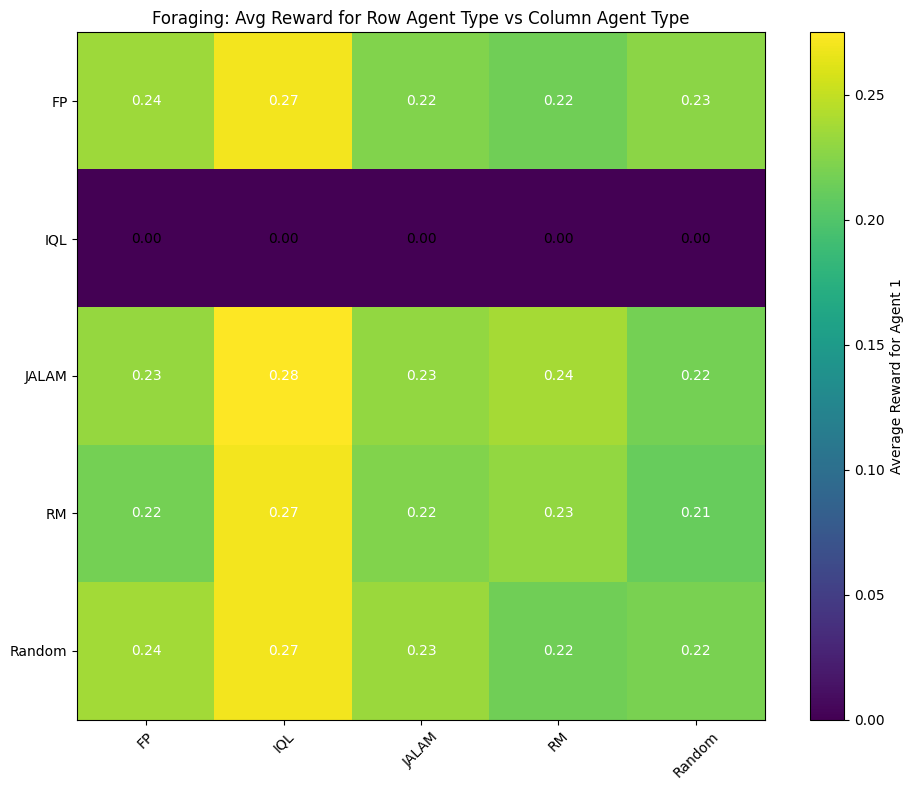

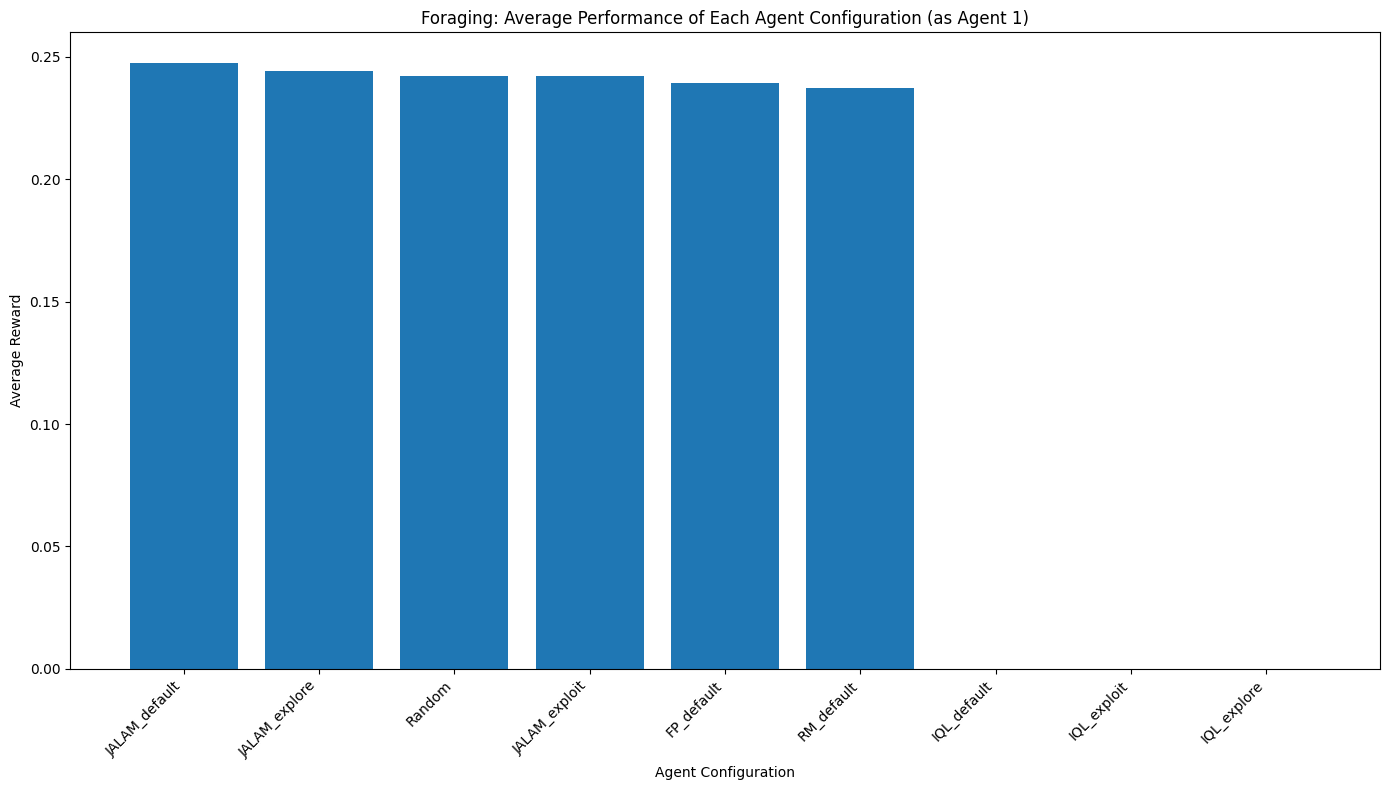

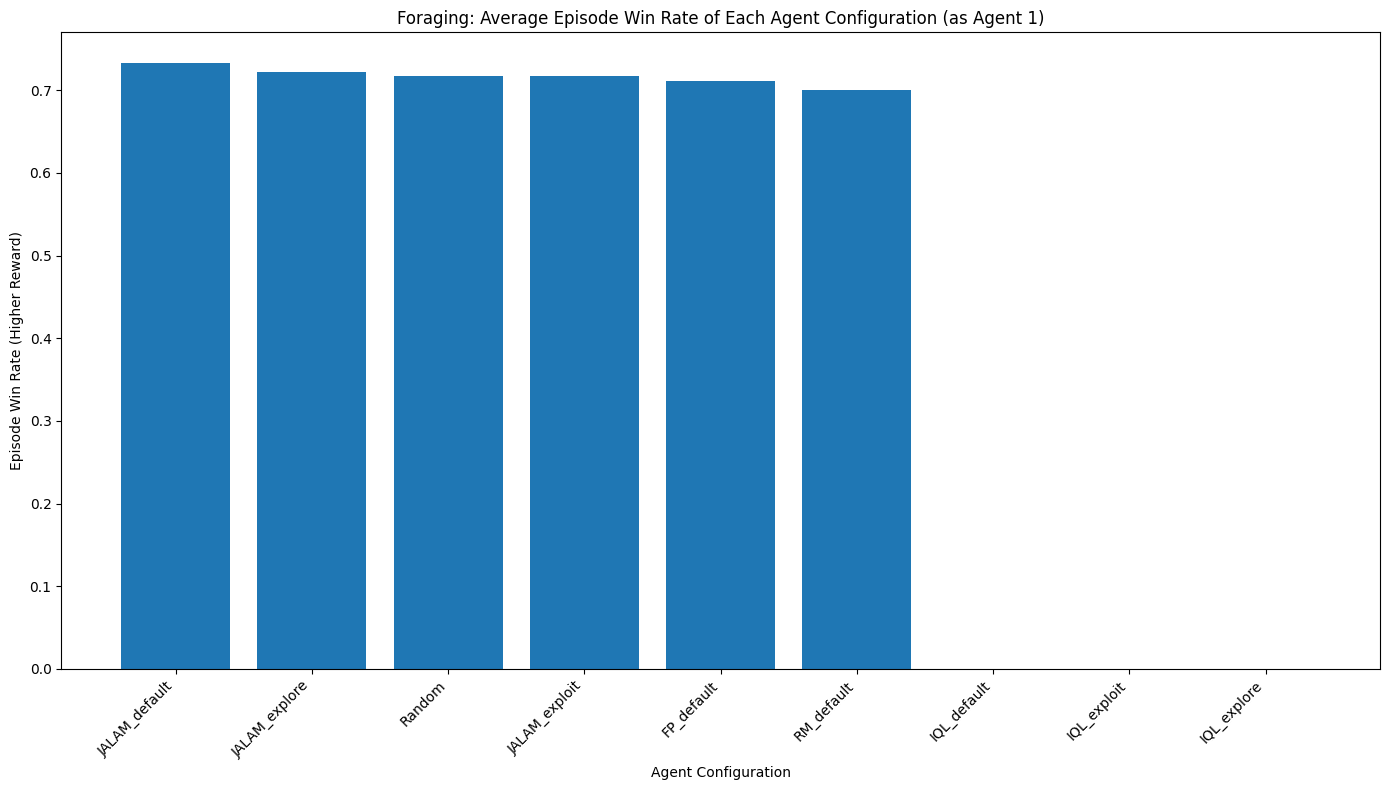


Foraging analysis complete. Charts show performance based on rewards.


In [ ]:
import pandas as pd
try:
    import seaborn as sns
    has_seaborn = True
except ImportError:
    has_seaborn = False

results_data_foraging = []
for match_key, res in results_foraging.items():
    agent1_name, agent2_name = match_key.split('_vs_')
    
    # Para Foraging, la "tasa de victoria" es menos clara. Usaremos recompensas.
    # Podríamos definir una "victoria" si la recompensa de un agente es mayor.
    hist1 = np.array(res['history_agent1'])
    hist2 = np.array(res['history_agent2'])
    
    # Contar episodios donde agent1 tuvo mayor recompensa, agent2 tuvo mayor, o empate.
    wins1 = np.sum(hist1 > hist2)
    wins2 = np.sum(hist2 > hist1)
    ties = np.sum(hist1 == hist2)
    total_episodes = len(hist1)

    results_data_foraging.append({
        'match': match_key,
        'agent1': agent1_name,
        'agent2': agent2_name,
        'agent1_avg_reward': res['avg_reward_agent1'],
        'agent2_avg_reward': res['avg_reward_agent2'],
        'agent1_win_rate': wins1 / total_episodes if total_episodes > 0 else 0,
        'agent2_win_rate': wins2 / total_episodes if total_episodes > 0 else 0,
        'tie_rate': ties / total_episodes if total_episodes > 0 else 0,
        'agent1_type': agent_creation_info[agent1_name]["type"], # Usar el tipo base
        'agent2_type': agent_creation_info[agent2_name]["type"], # Usar el tipo base
    })

df_results_foraging = pd.DataFrame(results_data_foraging)

print("\n=== Summary of Average Rewards (Foraging) ===\n")
for _, row in df_results_foraging.iterrows():
    print(f"{row['match']}: {row['agent1']} got {row['agent1_avg_reward']:.3f}, {row['agent2']} got {row['agent2_avg_reward']:.3f}")

print("\n=== Win/Tie/Loss Analysis (Foraging - based on episode rewards) ===\n")
for _, row in df_results_foraging.iterrows():
    print(f"Match {row['match']}:")
    print(f"  {row['agent1']} win rate (higher episode reward): {row['agent1_win_rate']:.1%}")
    print(f"  {row['agent2']} win rate (higher episode reward): {row['agent2_win_rate']:.1%}")
    print(f"  Tie rate (equal episode reward): {row['tie_rate']:.1%}")


print("\n=== Creating performance visualizations for Foraging... ===\n")

# Heatmap de recompensas promedio por tipo de agente
# Usamos los tipos base de agente (FP, RM, IQL, JALAM, Random)
agent_base_types = sorted(list(set(df_results_foraging['agent1_type'].unique()) | set(df_results_foraging['agent2_type'].unique())))

pivot_data_foraging_type = []
for type1 in agent_base_types:
    for type2 in agent_base_types:
        # Recompensas de agent1 cuando agent1 es type1 y agent2 es type2
        rewards_type1_vs_type2 = df_results_foraging[
            (df_results_foraging['agent1_type'] == type1) & 
            (df_results_foraging['agent2_type'] == type2)
        ]['agent1_avg_reward'].mean() # Promedio sobre diferentes configuraciones si hay varias

        pivot_data_foraging_type.append({
            'agent1_type': type1,
            'agent2_type': type2,
            'avg_reward_agent1': rewards_type1_vs_type2 if not pd.isna(rewards_type1_vs_type2) else 0 
            # Rellenar con 0 si no hay enfrentamientos (ej. Random vs Random si no se incluyó)
        })

df_pivot_foraging_type = pd.DataFrame(pivot_data_foraging_type)

if not df_pivot_foraging_type.empty:
    heatmap_table_type = df_pivot_foraging_type.pivot(index='agent1_type', columns='agent2_type', values='avg_reward_agent1')
    plt.figure(figsize=(10, 8))
    if has_seaborn:
        sns.heatmap(heatmap_table_type, annot=True, cmap='viridis', fmt='.2f') # 'viridis' es bueno para recompensas positivas
    else:
        plt.imshow(heatmap_table_type.fillna(0).values, cmap='viridis') # fillna(0) para imshow
        plt.colorbar(label='Average Reward for Agent 1')
        for i in range(heatmap_table_type.shape[0]):
            for j in range(heatmap_table_type.shape[1]):
                val = heatmap_table_type.iloc[i, j]
                plt.text(j, i, f'{val:.2f}' if not pd.isna(val) else 'N/A', 
                         ha='center', va='center', color='white' if val > heatmap_table_type.fillna(0).values.mean() else 'black') # Color de texto dinámico
        plt.xticks(range(len(heatmap_table_type.columns)), heatmap_table_type.columns, rotation=45)
        plt.yticks(range(len(heatmap_table_type.index)), heatmap_table_type.index)

    plt.title('Foraging: Avg Reward for Row Agent Type vs Column Agent Type')
    plt.tight_layout()
    plt.show()
else:
    print("No data for type-vs-type heatmap for Foraging.")


# Bar chart de rendimiento promedio por configuración de agente
df_summary_foraging = df_results_foraging.groupby('agent1')['agent1_avg_reward'].mean().reset_index()
df_summary_foraging = df_summary_foraging.sort_values('agent1_avg_reward', ascending=False)

plt.figure(figsize=(14, 8))
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_avg_reward', data=df_summary_foraging, palette="viridis")
else:
    plt.bar(df_summary_foraging['agent1'], df_summary_foraging['agent1_avg_reward'])
plt.title('Foraging: Average Performance of Each Agent Configuration (as Agent 1)')
plt.xlabel('Agent Configuration')
plt.ylabel('Average Reward')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar chart de "tasas de victoria" (basado en recompensa por episodio)
win_rates_foraging = df_results_foraging.groupby('agent1')['agent1_win_rate'].mean().reset_index()
win_rates_foraging = win_rates_foraging.sort_values('agent1_win_rate', ascending=False)

plt.figure(figsize=(14, 8))
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_win_rate', data=win_rates_foraging, palette="coolwarm")
else:
    plt.bar(win_rates_foraging['agent1'], win_rates_foraging['agent1_win_rate'])
plt.title('Foraging: Average Episode Win Rate of Each Agent Configuration (as Agent 1)')
plt.xlabel('Agent Configuration')
plt.ylabel('Episode Win Rate (Higher Reward)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nForaging analysis complete. Charts show performance based on rewards.")

## Conclusión General para Foraging

(Esta sección se llenará después de ejecutar el cuaderno y analizar los gráficos)

Consideraciones para Foraging:
- **Complejidad del estado**: El espacio de estados en Foraging es mucho mayor que en RPS. Esto puede afectar más a IQL y JALAM si la representación del estado no es adecuada.
- **Importancia de la exploración**: Encontrar comida en un mapa requiere una buena exploración. Los hiperparámetros de `epsilon` y `epsilon_decay` son cruciales.
- **Reward shaping**: Para IQL, `use_reward_shaping` puede ser muy útil para guiar al agente.
- **Duración de los episodios**: `max_steps` afecta cuánto tiempo tienen los agentes para recolectar comida.
- **FP y RM en Foraging**: Estos agentes no usan explícitamente el estado del juego (posiciones) para tomar decisiones, sino que aprenden políticas basadas en las acciones pasadas de los oponentes. Su desempeño podría ser limitado si el estado es muy relevante. RM podría adaptarse mejor si se calculan los regrets por estado, pero la implementación actual es más simple.

Se espera que los agentes de RL (IQL, JALAM) con buena configuración y representación de estado superen a FP, RM y Random en Foraging, dada la naturaleza del juego que requiere planificación y reacción al entorno.